# Titanic Prediction with Different Models


## Import Packages

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

## Common Functions

In [166]:
def save_results(Survived, test, path):
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Survived
    })
    submission.to_csv(path, index=False)

## Evaluate model

In [167]:
metrics = []

In [168]:
def evaluate(
    model, 
    name,
    validation_features, 
    validation_targets, 
    test_features, 
    columns = None
):
    if columns is None:
        feature_columns = validation_features.columns
    else:
        feature_columns = columns
    y_pred = model.predict(validation_features[feature_columns])
    if y_pred.dtype != int:
        if y_pred.shape[-1] == 2:
            y_pred = np.argmax(y_pred, axis=-1)
        if y_pred.shape[-1] == 1:
            y_pred = np.array(y_pred > 0.5, dtype=int)
    y_pred = y_pred.reshape(-1)
    accuracy = sklearn.metrics.accuracy_score(validation_targets, y_pred)
    f1 = sklearn.metrics.f1_score(validation_targets, y_pred)
    print("Accuracy Score:", accuracy)
    print("Classification Report:")
    print(sklearn.metrics.classification_report(validation_targets, y_pred))
    Survived = model.predict(test_features[feature_columns])
    
    if Survived.dtype != int:
        if Survived.shape[-1] == 2:
            Survived = np.argmax(Survived, axis=-1)
            proba = Survived[:, 1]
        elif Survived.shape[-1] == 1:
            proba = Survived.copy().reshape(-1)
            Survived = np.array(Survived > 0.5, dtype=int)
        else:
            proba = Survived.copy().reshape(-1)
    else:
        proba = Survived.copy().reshape(-1)
    Survived = np.array(Survived, dtype=int).reshape(-1)
    submit_path = f"{name}_submission.csv"
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Survived,
        "proba": proba
    })
    submission.to_csv(submit_path, index=False)
    metric = {
        "model": model,
        "name": name,
        "submit_path": submit_path,
        "accuracy": accuracy,
        "f1": f1
    }
    metrics.append(metric)

## Import datasets

In [169]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [170]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [171]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Wrangling

As we can see Age, Cabin and Fare information contains missing values, so we need to apply Missing Value  Imputation to them. The most common way is to replace categorical missing values with most fequent category and repalce numerical missing values with average value of that feature.

In [172]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [173]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [174]:
categorical_imputation_strategy = ["mode", "unknown", "knn"][1]
numerical_imputation_strategy = ["mean", "median", "knn"][2]

In [175]:
if categorical_imputation_strategy == "mode":
    train["Cabin"] = train["Cabin"].replace(np.NAN,  train["Cabin"].mode()[0])
    train["Embarked"] = train["Embarked"].replace(np.NAN, train["Embarked"].mode()[0])
if categorical_imputation_strategy == "unknown":
    train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
    train["Embarked"] = train["Embarked"].replace(np.NAN, "Unknown")
    test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
if categorical_imputation_strategy == "knn":
    print("To be continued")
if numerical_imputation_strategy == "mean":
    train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())
    test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
    test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())
if numerical_imputation_strategy == "median":
    train["Age"] = train["Age"].replace(np.NAN, train["Age"].median())
    test["Age"] = test["Age"].replace(np.NAN, test["Age"].median())
    test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].median())
if numerical_imputation_strategy == "knn":
    imputer = KNNImputer(n_neighbors=5)
    columns = ["Age", "Fare", "SibSp", "Parch"]
    train[columns] = imputer.fit_transform(train[columns])
    test[columns] = imputer.transform(test[columns])

## Data Preprocessing

### Add Deck feature

First letter of cabin stands for deck, it indicated the location and class of the Passengers so it had an impact to survive.

In [176]:
cabin_labels = sorted(set(list(train["Cabin"].unique()) + list(test["Cabin"].unique())))
print(cabin_labels[:30])

['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23', 'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22', 'B24', 'B26']


In [177]:
train["Deck"] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Deck"] = test["Cabin"].apply(lambda cabin: cabin[0])

### Add family member size and faimily member type Column

We can indicate family member size by SibSp and Parch feature: 

In [178]:
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

According to the EDA below, Family member size had a impact on Survival, but it was not a linear relationship, that was why it had a low pearson correlation score. So I will convert it to a categorical feature with single(1 family member), medium(2-4 family members), large(more than 4 members). I will add a Feature Toggle here to control whether to use this function

In [179]:
def convert_faimly_member_size(size):
    if size == 1:
        return "single"
    elif size < 5:
        return "medium"
    else:
        return "large"
should_add_family_member_type = True
if should_add_family_member_type:
    for data in [train, test]:
        data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)

### Handle Categorical Features

In [180]:
categorical_features = ["Sex", "Deck", "Embarked"]
if should_add_family_member_type:
    categorical_features.append("family_member_type")
categorical_label_dictionary = dict()
for feature in categorical_features:
    unique_labels = sorted(set(list(train[feature].unique()) + list(test[feature].unique())))
    for data in [train, test]:
        categorical_label_dictionary[feature] = unique_labels
        data[feature + "_value"] = data[feature].apply(lambda item: unique_labels.index(item))

Let's see after we preprocess, what does the data look like?

In [181]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,family_member_size,family_member_type,Sex_value,Deck_value,Embarked_value,family_member_type_value
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,Unknown,S,U,2.0,medium,1,8,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,C,2.0,medium,0,2,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,Unknown,S,U,1.0,single,0,8,2,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,C,2.0,medium,0,2,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,Unknown,S,U,1.0,single,1,8,2,2
5,6,0,3,"Moran, Mr. James",male,24.8,0.0,0.0,330877,8.4583,Unknown,Q,U,1.0,single,1,8,1,2
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S,E,1.0,single,1,4,2,2
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3.0,1.0,349909,21.0750,Unknown,S,U,5.0,large,1,8,2,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,11.1333,Unknown,S,U,3.0,medium,0,8,2,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,30.0708,Unknown,C,U,2.0,medium,0,8,0,1


## Exploratory Data Analysis

### Basic Statistic infos

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               891 non-null    int64  
 1   Survived                  891 non-null    int64  
 2   Pclass                    891 non-null    int64  
 3   Name                      891 non-null    object 
 4   Sex                       891 non-null    object 
 5   Age                       891 non-null    float64
 6   SibSp                     891 non-null    float64
 7   Parch                     891 non-null    float64
 8   Ticket                    891 non-null    object 
 9   Fare                      891 non-null    float64
 10  Cabin                     891 non-null    object 
 11  Embarked                  891 non-null    object 
 12  Deck                      891 non-null    object 
 13  family_member_size        891 non-null    float64
 14  family_mem

In [183]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Deck_value,Embarked_value,family_member_type_value
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,30.094880,0.523008,0.381594,32.204208,1.904602,0.647587,6.716049,1.538721,1.533109
std,257.353842,0.486592,0.836071,13.497779,1.102743,0.806057,49.693429,1.613459,0.477990,2.460739,0.794231,0.623305
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,8.000000,1.000000,1.000000
50%,446.000000,0.000000,3.000000,28.500000,0.000000,0.000000,14.454200,1.000000,1.000000,8.000000,2.000000,2.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000,8.000000,2.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,8.000000,3.000000,2.000000


### What's the factor to survive?
As we can see it's related to Gender, PClass, Status, Fare, Deck and Embarked. 

In [184]:
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Deck_value                 -0.301116
Fare                        0.257307
Embarked_value             -0.163517
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.058335
SibSp                      -0.035322
family_member_size          0.016639
PassengerId                -0.005007
Name: Survived, dtype: float64

In [185]:
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Deck_value', 'Embarked_value', 'family_member_type_value']


#### Gender
Women have a higher Survival rate than Men.

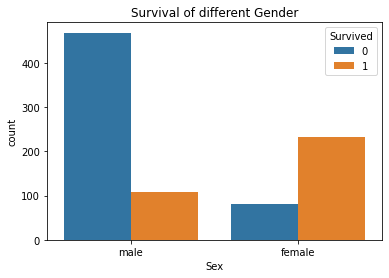

In [186]:
sns.countplot(x="Sex", hue="Survived", data=train)
plt.title("Survival of different Gender")
plt.show()

#### Age


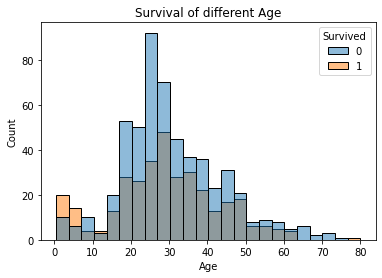

In [187]:
sns.histplot(x="Age", hue="Survived", data=train)
plt.title("Survival of different Age")
plt.show()

#### Pclass
- Passengers from Pclass 1 had 62% Survival Rate;
- Passengers from Pclass 2 had 47% Survival Rate;
- Passengers from Pclass 3 had 24% Survival Rate;

In [188]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

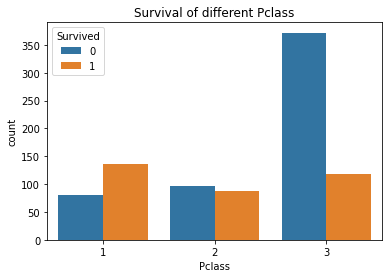

In [189]:
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.title("Survival of different Pclass")
plt.show()

#### Fare
Most of the tickets were less than 100 pounds. Only about 1 / 5 with fare around 10 pounds survived.

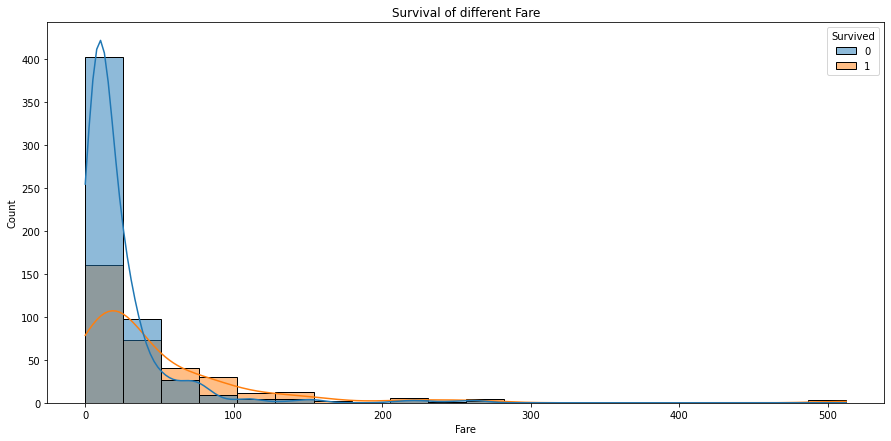

In [190]:
plt.figure(figsize=(15, 7))
sns.histplot(x="Fare", hue="Survived", bins=20, kde=True, data=train)
plt.title("Survival of different Fare")
plt.show()

#### Deck
- More than half Passengers from Deck C, D, E, F, G survived;
- Less than half Passengers from Deck A,B survived;
- 30% of Passengers with unknown Deck survived;
- Almost no Passengers from Deck T survived.

In [191]:
train.groupby("Deck")["Survived"].mean()

Deck
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

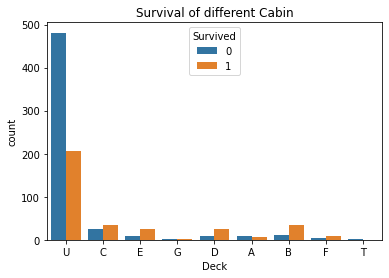

In [192]:
sns.countplot(x="Deck", hue="Survived", data=train)
plt.title("Survival of different Cabin")
plt.show()

#### Embarked
- About 1 / 3 passengers from Embarked Q, S survived;
- About half passengers from Embarked C survived;

In [193]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C          0.553571
Q          0.389610
S          0.336957
Unknown    1.000000
Name: Survived, dtype: float64

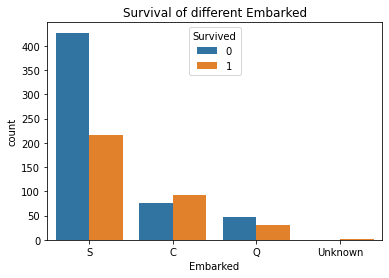

In [194]:
sns.countplot(x="Embarked", hue="Survived", data=train)
plt.title("Survival of different Embarked")
plt.show()

#### SibSp (Number of siblings or spouse)
- Passengers without siblings or spouse had 1 / 3 Survival Rate.
- Passengers with one or two siblings or spouse had about 1 / 2 Survival Rate.
- Passengers with more than two siblings or spouse were less likely to survive.

In [195]:
train.groupby("SibSp")["Survived"].mean()

SibSp
0.0    0.345395
1.0    0.535885
2.0    0.464286
3.0    0.250000
4.0    0.166667
5.0    0.000000
8.0    0.000000
Name: Survived, dtype: float64

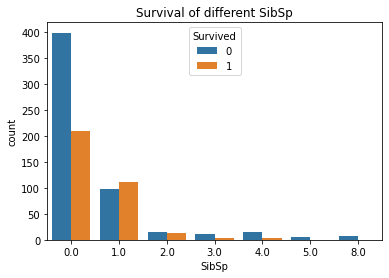

In [196]:
sns.countplot(x="SibSp", hue="Survived", data=train)
plt.title("Survival of different SibSp")
plt.show()

#### Parch (Number of parents or children)
- Passengers without parents or children had 1 / 3 survival rate.
- Passengers with 1 - 3 parents or children had 1 / 2 survival rate.
- Passengers with more than 4 parents or children were less likely to survive.


In [197]:
train.groupby("Parch")["Survived"].mean()

Parch
0.0    0.343658
1.0    0.550847
2.0    0.500000
3.0    0.600000
4.0    0.000000
5.0    0.200000
6.0    0.000000
Name: Survived, dtype: float64

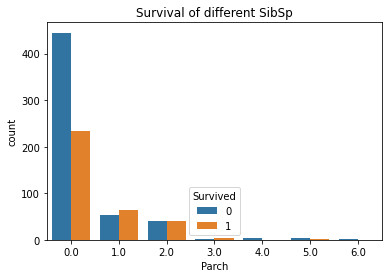

In [198]:
sns.countplot(x="Parch", hue="Survived", data=train)
plt.title("Survival of different SibSp")
plt.show()

#### Family member size
- Those who were alone (1 family member size) had 1 / 3 Survival Rate.
- Those who had 2 - 4 family member size had more than 1 / 2 Survival Rate.
- Those who had 5 - 11 family member size were less likely to survive.

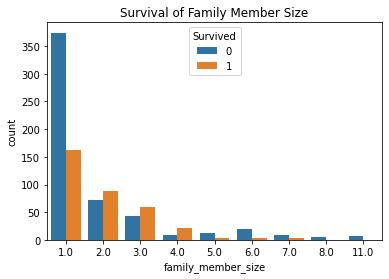

In [199]:
sns.countplot(x="family_member_size", hue="Survived", data=train)
plt.title("Survival of Family Member Size")
plt.show()

After converting family member size to categorical feature, the relation between family member size and survival rate were more obvious.

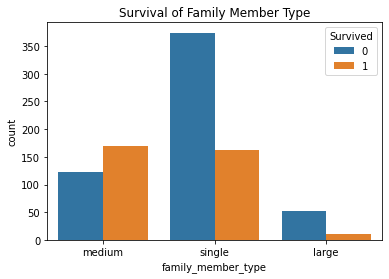

In [200]:
if should_add_family_member_type:
    sns.countplot(x="family_member_type", hue="Survived", data=train)
    plt.title("Survival of Family Member Type")
    plt.show()

## More data Preprocessing

In [201]:
train_test = pd.concat([train, test])
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,family_member_size,family_member_type,Sex_value,Deck_value,Embarked_value,family_member_type_value
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,Unknown,S,U,2.0,medium,1,8,2,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,C,2.0,medium,0,2,0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,Unknown,S,U,1.0,single,0,8,2,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,C,2.0,medium,0,2,2,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,Unknown,S,U,1.0,single,1,8,2,2


### Convert Categorical features to one hot features

In [202]:
categorical_columns_to_one_hot = ["Sex", "Deck", "Embarked"]
if should_add_family_member_type:
    categorical_columns_to_one_hot.append("family_member_type")
for feature in categorical_columns_to_one_hot:
    items = pd.get_dummies(train_test[feature + "_value"])
    labels = categorical_label_dictionary[feature]
    items.columns = [feature + "_" + labels[column] for column in list(items.columns)]
    train_test[items.columns] = items
    train_test.pop(feature + "_value")

Calucate mean and std value for future use.

In [203]:
mean_value = train_test.mean()
std_value = train_test.std()
mean_value.pop("Survived")
_ = std_value.pop("Survived")

In [204]:
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown,family_member_type_large,family_member_type_medium,family_member_type_single
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,...,0,0,1,0,0,1,0,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,...,0,0,0,1,0,0,0,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,...,0,0,1,0,0,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,...,0,0,0,0,0,1,0,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,...,0,0,1,0,0,1,0,0,0,1


### Remove unused columns

In [205]:
for column in ["Name", "Sex", "Ticket", "Cabin", "Deck", "Embarked", "family_member_size", "family_member_type"]:
    if column in train_test.columns:
        train_test.pop(column)

In [206]:
train_features = train_test.iloc[0: len(train)]
test_features = train_test.iloc[len(train):]

In [207]:
train_features.pop("PassengerId")
test_features.pop("Survived")
train_features.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,...,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown,family_member_type_large,family_member_type_medium,family_member_type_single
0,0.0,3,22.0,1.0,0.0,7.2500,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1,1.0,1,38.0,1.0,0.0,71.2833,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,1.0,3,26.0,0.0,0.0,7.9250,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,1.0,1,35.0,1.0,0.0,53.1000,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,3,35.0,0.0,0.0,8.0500,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


In [208]:
test_features.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,...,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown,family_member_type_large,family_member_type_medium,family_member_type_single
0,892,3,34.5,0.0,0.0,7.8292,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
1,893,3,47.0,1.0,0.0,7.0000,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,894,2,62.0,0.0,0.0,9.6875,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,895,3,27.0,0.0,0.0,8.6625,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
4,896,3,22.0,1.0,1.0,12.2875,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1


### Train Validation Split

In [209]:
validation_split = 0.2

In [210]:
train_features, validation_features = model_selection.train_test_split(train_features, test_size=validation_split, stratify=train_features["Survived"], random_state=42)
print(train_features.shape, validation_features.shape)

(712, 24) (179, 24)


## Feature Scaling

In [214]:
train_features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,Deck_C,...,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown,family_member_type_large,family_member_type_medium,family_member_type_single
692,3,29.6,0.0,0.0,56.4958,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
481,2,36.4,0.0,0.0,0.0000,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
527,1,30.8,0.0,0.0,221.7792,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
855,3,18.0,0.0,1.0,9.3500,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
801,2,31.0,1.0,1.0,26.2500,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [215]:
data_scaling_strategies = ["none", "max", "standard"]
data_scaling_strategy = data_scaling_strategies[2]
if data_scaling_strategy == data_scaling_strategies[1]:
    features_max = pd.concat([train_features, validation_features]).max()
    train_features = train_features / features_max
    validation_features = validation_features / features_max
    test_features[train_features.columns] = test_features[train_features.columns] / features_max
if data_scaling_strategy == data_scaling_strategies[2]:
    for data in [train_features, validation_features, test_features]:
        columns_to_scale = ["Age", "Fare"]
        data.loc[:, columns_to_scale] = (data.loc[:, columns_to_scale]  - mean_value[columns_to_scale]) / std_value[columns_to_scale]
print(train_features.shape)
print(test_features.shape)

(712, 23)
(418, 24)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


## Model Development & Evaluation
I will try different Models and use results from best Model.

### TensorFlow DNN

<AxesSubplot:>

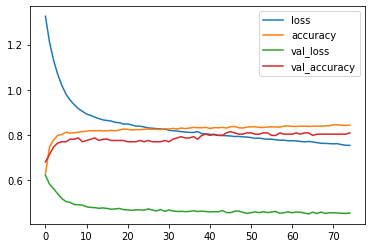

In [266]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_features.shape[1])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    train_features, train_targets, 
    epochs=400, 
    validation_data=(validation_features, validation_targets), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [267]:
evaluate(
    model, 
    "dnn",
    validation_features, 
    validation_targets, 
    test_features,
    columns=validation_features.columns
)

Accuracy Score: 0.8100558659217877
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84       110
         1.0       0.75      0.77      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



### Logistic Regression

In [225]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,family_member_size,family_member_type,Sex_value,Deck_value,Embarked_value,family_member_type_value
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,Unknown,S,U,2.0,medium,1,8,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,C,2.0,medium,0,2,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,Unknown,S,U,1.0,single,0,8,2,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,C,2.0,medium,0,2,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,Unknown,S,U,1.0,single,1,8,2,2


In [252]:
logitistc_related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
logitistc_related_columns.remove("Survived")
logitistc_related_columns.remove('family_member_type_value')
logitistc_related_columns

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Deck_value', 'Embarked_value']

In [259]:

from sklearn.linear_model import LogisticRegression
best_logit = None
best_solver = ""
best_logit_score = 0
logit_train_features, logit_val_features = train_test_split(train[logitistc_related_columns +  ["Survived"]], test_size=0.2, random_state=48)
logit_train_targets = logit_train_features.pop("Survived")
logit_val_targets = logit_val_features.pop("Survived")

for solver in ['newton-cg', 'lbfgs', 'liblinear']:
    logit = LogisticRegression(solver=solver)
    logit.fit(logit_train_features, logit_train_targets)
    score = logit.score(logit_val_features, logit_val_targets)
    if score > best_logit_score:
        best_solver = solver
        best_logit_score = score
        best_logit = logit
print("Best Solver:", best_solver, "Score:", best_logit_score)

Best Solver: liblinear Score: 0.8044692737430168


### KNN

## XGBoost Classifier

In [261]:
def get_value(key1, key2, value, parameters, best_index):
    return parameters[key1][best_index[key1]] if key1 != key2 else value

def find_best_model_with_xgboost(
    train_features, 
    train_targets,
    validation_features,
    validation_targets,
    parameters,
    columns = None
):
    train_f = train_features
    val_f = validation_features
    if columns != None:
        train_f = train_features[columns]
        val_f = validation_features[columns]
    else: 
        train_f = train_features
        val_f = validation_features
    all_keys = parameters.keys()
    best_index = {key: 0 for key in all_keys}
    best_xgb_score = 0
    best_xgb_model = None
    for key in all_keys:
        values = parameters[key]
        current_best_model = None
        current_best_score = 0
        for index, value in enumerate(values):
            learning_rate = get_value("learning_rate", key, value, parameters, best_index)
            max_depth = get_value("max_depth", key, value, parameters, best_index)
            gamma = get_value("gamma", key, value, parameters, best_index)
            xgb = XGBClassifier(
                max_depth=max_depth,
                learning_rate=learning_rate,
                gamma=gamma
            )
            xgb.fit(
                train_f, 
                train_targets, 
                early_stopping_rounds=10, 
                eval_metric="logloss", 
                eval_set=[(val_f, validation_targets)], 
                verbose=False
            )
            score = xgb.score(validation_features, validation_targets)
            if score > current_best_score:
                current_best_score = score
                current_best_model = xgb
                best_index[key] = index
            if score > best_xgb_score: 
                best_xgb_score = score
                best_xgb_model = xgb
    return best_xgb_model, best_xgb_score

In [265]:
from xgboost import XGBClassifier
hyper_parameters = {
    "max_depth": list(range(5, 15)),
    "learning_rate": [0.1, 0.15, 0.2, 0.25, 0.3],
    "gamma": [0.5, 1, 1.5, 2.0]
}
best_xgb_model, best_xgb_score = find_best_model_with_xgboost(
    train_features, 
    train_targets,
    validation_features,
    validation_targets,
    hyper_parameters
)
print("Best Model:", best_xgb_model, " Score: ", best_xgb_score)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)  Score:  0.8212290502793296


In [ ]:
evaluate(
    best_xgb_score, 
    "xgboost",
    validation_features, 
    validation_targets, 
    test_features
)

## Catboost

## Show LeaderBoards

In [ ]:
lb = pd.DataFrame(metrics)
lb.pop("model")
lb.head()

### Top models by ordered by Accuracy

In [ ]:
lb.sort_values(by="accuracy", ascending=False)